### Naive Bayes Probability Estimates Are Inaccurate

The Naive Bayes model is an example of a *probabilistic graphical model*. In particular, it is the simplest example of a *Bayesian Network*.

In [1]:
import lib.dataset
from lib.naive_bayes_evaluator import NaiveBayesEvaluator
from lib.naive_bayes_model import NaiveBayesModel

RAW_DATASET = lib.dataset.RawDataset.get()
(training_set, test_set) = RAW_DATASET.split(ratio = 0.80)

print(f"total_number of emails: {len(RAW_DATASET.ham_emails) + len(RAW_DATASET.spam_emails)}")
print(f"number of training emails: {len(training_set.ham_emails) + len(training_set.spam_emails)}")
print(f"number of test emails: {len(test_set.ham_emails) + len(test_set.spam_emails)}")

model = NaiveBayesModel(
    training_set.feature_probabilities().filter(reach_limit = 100),
    use_negative_features = False
)

print(NaiveBayesEvaluator.spam_probability_at_different_scores(
    model,
    test_set
))

total_number of emails: 5172
number of training emails: 4181
number of test emails: 991
1.0
1.5
2.33333333333
4.0
9.0
[(0.5, {'limit': 0.5, 'expected_rate': 0.91064650168097672, 'true_rate': 0.9525862068965517}), (0.59999999999999998, {'limit': 0.59999999999999998, 'expected_rate': 0.9240938475636995, 'true_rate': 0.9555555555555556}), (0.69999999999999996, {'limit': 0.69999999999999996, 'expected_rate': 0.93292936845285546, 'true_rate': 0.9541284403669725}), (0.79999999999999993, {'limit': 0.79999999999999993, 'expected_rate': 0.93954518363462225, 'true_rate': 0.9523809523809523}), (0.89999999999999991, {'limit': 0.89999999999999991, 'expected_rate': 0.95228004210517281, 'true_rate': 0.96})]


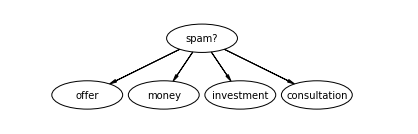

In [2]:
%matplotlib inline
import examples.pgm_diagram_example

examples.pgm_diagram_example.run()